In [4]:
import numpy as np
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector

# Exercise
Trotter evolution is the first order approximation in a class of algorithms called product formulas. Higher orders are simply called product formulas of order $2k$ (they are defined only for even orders as they are symmetric). The second order product formula ($k=1$) for time $t$ and $L$ non-commuting Hamiltonian terms reads
$$
S_1(t) = \prod_{n=1}^L e^{-i H_n t/2} \prod_{n=L}^1 e^{-i H_n t/2} \ .
$$
For $N$ time steps, the time evolution operator is then apprixmated by
$$
U(t) \approx \bigl[ S_1(t/N) \bigr]^N
$$

We have seen how to time evolve an Ising and a Heisenberg Hamiltonian using first order Trotter evolution. In this exercise, we will study the algorithmic error of product formulas in more detail.
We will use a transverse field Ising model to do so.
$$ H = J \sum_i Z_i Z_{i+1} + h \sum_i X_i$$
for $N=4$ sites with $J = 1, h = 0.5$, periodic boundary conditions (PBC).
1. Implement both first and second-order product formula using the `PauliEvolutionGate`
    - print the Trotter circuits for two Trotter steps ($t = 1$, $\delta t = 0.5$) in terms of $R_x$ and $R_{zz}$ gates (you can use `QuantumCircuit.decompose().decompose()` to decompose it from the high-level `PauliEvolutionGate` into single- and two-qubit gates).
2. Do the time evolution with both the first and the second order product formula for
    - up to $t = 4$
    - for $N_t \in \{ 5, 10, 20, 50, 100 \}$ time steps.
3. Compute the **infidelity** $1 - |\langle \psi_{\rm exact}(t) | \psi_{\rm trotter}(t) \rangle|^2$ between the exact state at $t = 4$ and the approximate state evolved with the respective product formula.
    - print the final infidelities for each $N_t$ and both for the first and the second order product formula
    - plot the infidelities vs $N_t$ with logarithmic y-scale

In [5]:
def get_H_op(N, J, h, pbc):
    """Define the two non-commuting parts of the Hamiltonian separately."""
    
    z_op_strings = []
    for i in range(N - 1):
        z_op_strings.append((N - 2 - i)*"I" + "Z" + "Z" + i*"I")
    # last term for periodic BC
    if pbc and N > 2:
        z_op_strings.append("Z" + (N - 2)*"I" + "Z")
    
    x_op_strings = []
    for i in range(N):
        x_op_strings.append(((N - 1 - i)*"I" + "X" + i*"I"))

    z_ops = SparsePauliOp(data=z_op_strings, coeffs=[J] * (N if (pbc and N > 2) else N - 1))
    x_ops = SparsePauliOp(data=x_op_strings, coeffs=[h] * N)
    
    return z_ops, x_ops

In [6]:
# define basic parameters
N = 4
J = 1
h = 0.5
pbc = True

In [7]:
z_ops, x_ops = get_H_op(N, J, h, pbc)
H_op = z_ops + x_ops
H_mat = H_op.to_matrix()

mag_ave = SparsePauliOp(data=[((N - 1 - i)*"I" + "Z" + i*"I")
                        for i in range(N)], coeffs=[1 / N] * N)
                        
print(f"H_Z =\n{z_ops}")
print(f"H_X =\n{x_ops}")
print(f"H_ising =\n{H_op}")
print(f"M_average =\n{mag_ave}")

mag_ave = mag_ave.to_matrix()

H_Z =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
H_X =
SparsePauliOp(['IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
H_ising =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
M_average =
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


### 2. Implement a method `heisenberg_trotter_circ` to obtain the circuit for Trotter evolution.
- Print the Trotter circuit for 1 Trotter step with a steps size of $\delta t = 0.25$.


In [8]:
def ising_trotter_circ(H_list, N, t_final, dt, order=1, init_circ=None):
    """This method implements a Trotter circuit for the time evolution of the transverse field Ising model."""
    Nt = int(np.round(t_final / dt))

    if order == 2:
        dt /= 2

    # ZZ-gate
    z_ops = H_list[0]
    z_circ = PauliEvolutionGate(z_ops, dt)

    x_ops = H_list[1]
    x_circ = PauliEvolutionGate(x_ops, dt)

    qreg = QuantumRegister(N)
    evo_circ = QuantumCircuit(qreg)
    if init_circ is not None:
        evo_circ.append(init_circ, qreg)
    for _ in range(Nt):
        if order == 1:
            evo_circ.append(x_circ, qreg)
            evo_circ.append(z_circ, qreg)
        elif order == 2:
            evo_circ.append(x_circ, qreg)
            evo_circ.append(z_circ, qreg)
            evo_circ.append(z_circ, qreg)
            evo_circ.append(x_circ, qreg)
        evo_circ.barrier()

    return evo_circ

In [9]:
circ = ising_trotter_circ([z_ops, x_ops], N, 1, 0.25)
circ.decompose().decompose().draw()

┌──────────┐                                         ░ ┌──────────┐»
q0_0: ┤ Rx(0.25) ├─■─────────────────────────────■─────────░─┤ Rx(0.25) ├»
      ├──────────┤ │ZZ(0.5)                      │         ░ ├──────────┤»
q0_1: ┤ Rx(0.25) ├─■─────────■───────────────────┼─────────░─┤ Rx(0.25) ├»
      ├──────────┤           │ZZ(0.5)            │         ░ ├──────────┤»
q0_2: ┤ Rx(0.25) ├───────────■─────────■─────────┼─────────░─┤ Rx(0.25) ├»
      ├──────────┤                     │ZZ(0.5)  │ZZ(0.5)  ░ ├──────────┤»
q0_3: ┤ Rx(0.25) ├─────────────────────■─────────■─────────░─┤ Rx(0.25) ├»
      └──────────┘                                         ░ └──────────┘»
«                                               ░ ┌──────────┐          »
«q0_0: ─■─────────────────────────────■─────────░─┤ Rx(0.25) ├─■────────»
«       │ZZ(0.5)                      │         ░ ├──────────┤ │ZZ(0.5) »
«q0_1: ─■─────────■───────────────────┼─────────░─┤ Rx(0.25) ├─■────────»
«                 │ZZ(0.5)            │         ░ ├──────────┤          »
«q0_2: ───────────■─────────■─────────┼─────────░─┤ Rx(0.25) ├──────────»
«                           │ZZ(0.5)  │ZZ(0.5)  ░ ├──────────┤          »
«q0_3: ─────────────────────■─────────■─────────░─┤ Rx(0.25) ├──────────»
«                                               ░ └──────────┘          »
«                                     ░ ┌──────────┐                    »
«q0_0: ─────────────────────■─────────░─┤ Rx(0.25) ├─■──────────────────»
«                           │         ░ ├──────────┤ │ZZ(0.5)           »
«q0_1: ─■───────────────────┼─────────░─┤ Rx(0.25) ├─■─────────■────────»
«       │ZZ(0.5)            │         ░ ├──────────┤           │ZZ(0.5) »
«q0_2: ─■─────────■─────────┼─────────░─┤ Rx(0.25) ├───────────■────────»
«                 │ZZ(0.5)  │ZZ(0.5)  ░ ├──────────┤                    »
«q0_3: ───────────■─────────■─────────░─┤ Rx(0.25) ├────────────────────»
«                                     ░ └──────────┘                    »
«                           ░ 
«q0_0: ───────────■─────────░─
«                 │         ░ 
«q0_1: ───────────┼─────────░─
«                 │         ░ 
«q0_2: ─■─────────┼─────────░─
«       │ZZ(0.5)  │ZZ(0.5)  ░ 
«q0_3: ─■─────────■─────────░─
«                           ░

In [10]:
init_circ = QuantumCircuit(N)
psi_init = Statevector(init_circ).data

t_final = 4
psi_exact = expm_multiply(-1j * t_final * H_mat, psi_init)

# dt_list = [2, 1, 0.5, 0.25, 0.1]
# Nt_list = [int(t_final / dt) for dt in dt_list]
Nt_list = [5, 10, 20, 50, 100]
dt_list = [t_final / Nt for Nt in Nt_list]

In [11]:
final_infid_order1 = []

for i, dt in enumerate(dt_list):
    Nt = Nt_list[i]
    t_eval = np.linspace(0, t_final, Nt + 1)

    trotter_circ_res = []
    for t in t_eval:
        circ = ising_trotter_circ([z_ops, x_ops], N, t, dt, init_circ=init_circ)
        psi = Statevector(circ).data
        trotter_circ_res.append(np.abs(np.conj(psi).dot(mag_ave).dot(psi)))

    overlap = np.conj(psi).dot(psi_exact)
    fidelity = overlap.real**2 + overlap.imag**2
    final_infid_order1.append(1 - fidelity)
    print(final_infid_order1[-1])


0.35795597724481765
0.05112775511519119
0.010418060340360302


0.001630883418908713
0.0004127652703208584


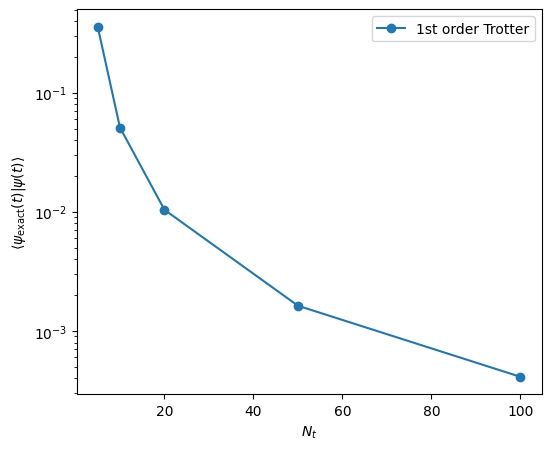

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
axs.plot(Nt_list, final_infid_order1, marker='o', label="1st order Trotter")
axs.set_yscale("log")
axs.set_xlabel(rf"$N_t$")
axs.set_ylabel(rf"$\langle \psi_{{\rm exact}}(t) | \psi(t) \rangle$")
axs.legend()

In [13]:
circ = ising_trotter_circ([z_ops, x_ops], N, 1, 0.25, order=2)
circ.decompose().decompose().draw()

┌───────────┐                                                       »
q191_0: ┤ Rx(0.125) ├─■────────────────────────────────■──────────■─────────»
        ├───────────┤ │ZZ(0.25)                        │          │ZZ(0.25) »
q191_1: ┤ Rx(0.125) ├─■──────────■─────────────────────┼──────────■─────────»
        ├───────────┤            │ZZ(0.25)             │                    »
q191_2: ┤ Rx(0.125) ├────────────■──────────■──────────┼────────────────────»
        ├───────────┤                       │ZZ(0.25)  │ZZ(0.25)            »
q191_3: ┤ Rx(0.125) ├───────────────────────■──────────■────────────────────»
        └───────────┘                                                       »
«                                           ┌───────────┐ ░ ┌───────────┐»
«q191_0: ─────────────────────────■─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├»
«                   ┌───────────┐ │         └───────────┘ ░ ├───────────┤»
«q191_1: ─■─────────┤ Rx(0.125) ├─┼───────────────────────░─┤ Rx(0.125) ├»
«         │ZZ(0.25) └───────────┘ │         ┌───────────┐ ░ ├───────────┤»
«q191_2: ─■───────────■───────────┼─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├»
«                     │ZZ(0.25)   │ZZ(0.25) ├───────────┤ ░ ├───────────┤»
«q191_3: ─────────────■───────────■─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├»
«                                           └───────────┘ ░ └───────────┘»
«                                                                          »
«q191_0: ─■────────────────────────────────■──────────■────────────────────»
«         │ZZ(0.25)                        │          │ZZ(0.25)            »
«q191_1: ─■──────────■─────────────────────┼──────────■──────────■─────────»
«                    │ZZ(0.25)             │                     │ZZ(0.25) »
«q191_2: ────────────■──────────■──────────┼─────────────────────■─────────»
«                               │ZZ(0.25)  │ZZ(0.25)                       »
«q191_3: ───────────────────────■──────────■───────────────────────────────»
«                                                                          »
«                                ┌───────────┐ ░ ┌───────────┐           »
«q191_0: ──────────────■─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├─■─────────»
«        ┌───────────┐ │         └───────────┘ ░ ├───────────┤ │ZZ(0.25) »
«q191_1: ┤ Rx(0.125) ├─┼───────────────────────░─┤ Rx(0.125) ├─■─────────»
«        └───────────┘ │         ┌───────────┐ ░ ├───────────┤           »
«q191_2: ──■───────────┼─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├───────────»
«          │ZZ(0.25)   │ZZ(0.25) ├───────────┤ ░ ├───────────┤           »
«q191_3: ──■───────────■─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├───────────»
«                                └───────────┘ ░ └───────────┘           »
«                                                                            »
«q191_0: ───────────────────────■──────────■─────────────────────────────────»
«                               │          │ZZ(0.25)            ┌───────────┐»
«q191_1: ─■─────────────────────┼──────────■──────────■─────────┤ Rx(0.125) ├»
«         │ZZ(0.25)             │                     │ZZ(0.25) └───────────┘»
«q191_2: ─■──────────■──────────┼─────────────────────■───────────■──────────»
«                    │ZZ(0.25)  │ZZ(0.25)                         │ZZ(0.25)  »
«q191_3: ────────────■──────────■─────────────────────────────────■──────────»
«                                                                            »
«                   ┌───────────┐ ░ ┌───────────┐                      »
«q191_0: ─■─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├─■────────────────────»
«         │         └───────────┘ ░ ├───────────┤ │ZZ(0.25)            »
«q191_1: ─┼───────────────────────░─┤ Rx(0.125) ├─■──────────■─────────»
«         │         ┌───────────┐ ░ ├───────────┤            │ZZ(0.25) »
«q191_2: ─┼─────────┤ Rx(0.125) ├─░─┤ Rx(0.125) ├────────────■─────────»
«         │ZZ(0.25) ├───────────┤ ░ ├───────────┤                      »
«q191_3: ─■─────────┤ Rx(0.125) ├─░─┤ Rx(

In [14]:
final_infid_order2 = []

for i, dt in enumerate(dt_list):
    Nt = Nt_list[i]
    t_eval = np.linspace(0, t_final, Nt + 1)

    trotter_circ_res = []
    for t in t_eval:
        circ = ising_trotter_circ([z_ops, x_ops], N, t, dt, order=2, init_circ=init_circ)
        psi = Statevector(circ).data
        trotter_circ_res.append(np.abs(np.conj(psi).dot(mag_ave).dot(psi)))

    overlap = np.conj(psi).dot(psi_exact)
    fidelity = overlap.real**2 + overlap.imag**2
    final_infid_order2.append(1 - fidelity)
    print(final_infid_order2[-1])


0.11767069351768467
0.004542611295253685
0.0002861226312058651
7.401285095687271e-06
4.6337128822848683e-07


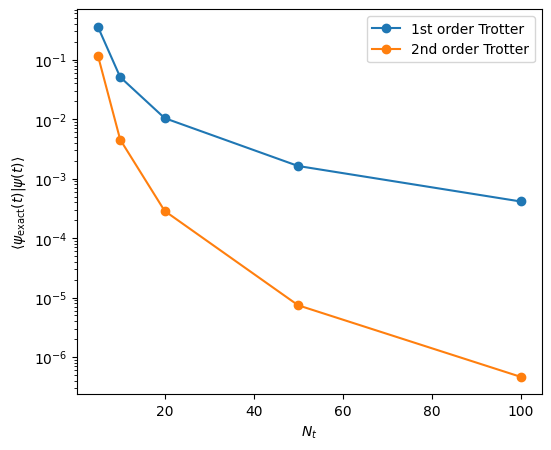

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
axs.plot(Nt_list, final_infid_order1, marker='o', label="1st order Trotter")
axs.plot(Nt_list, final_infid_order2, marker='o', label="2nd order Trotter")
# axs.plot(Nt_list, [0.1*(2 * t_final)**2/(x**2) for x in Nt_list], marker='o', label="1st order error")
# axs.plot(Nt_list, [(0.5*2 * t_final)**3/(x**4) for x in Nt_list], marker='o', label="2nd order error")
axs.set_yscale("log")
axs.set_xlabel(rf"$N_t$")
axs.set_ylabel(rf"$\langle \psi_{{\rm exact}}(t) | \psi(t) \rangle$")
axs.legend()

In [13]:
Nt = 20
t_final_list = [1, 2, 5, 10, 20]

final_infid_tf_order1 = []
for i, t_final in enumerate(t_final_list):
    # Nt = int(t_final / dt)
    dt = t_final / Nt
    t_eval = np.linspace(0, t_final, Nt + 1)

    trotter_circ_res = []
    for t in t_eval:
        circ = ising_trotter_circ([z_ops, x_ops], N, t, dt, init_circ=init_circ)
        psi = Statevector(circ).data
        trotter_circ_res.append(np.abs(np.conj(psi).dot(mag_ave).dot(psi)))

    psi_exact = expm_multiply(-1j * t_final * H_mat, psi_init)
    overlap = np.conj(psi).dot(psi_exact)
    fidelity = overlap.real**2 + overlap.imag**2
    final_infid_tf_order1.append(1 - fidelity)
    print(dt, final_infid_tf_order1[-1])

0.05 0.0014750139779339255
0.1 0.0037677867389133146
0.25 0.03267392656902557
0.5 0.135667053027816
1.0 0.9731724982955658


In [14]:
final_infid_tf_order2 = []

for i, t_final in enumerate(t_final_list):
    # Nt = int(t_final / dt)
    dt = t_final / Nt
    t_eval = np.linspace(0, t_final, Nt + 1)

    trotter_circ_res = []
    for t in t_eval:
        circ = ising_trotter_circ([z_ops, x_ops], N, t, dt, order=2, init_circ=init_circ)
        psi = Statevector(circ).data
        trotter_circ_res.append(np.abs(np.conj(psi).dot(mag_ave).dot(psi)))

    psi_exact = expm_multiply(-1j * t_final * H_mat, psi_init)
    overlap = np.conj(psi).dot(psi_exact)
    fidelity = overlap.real**2 + overlap.imag**2
    final_infid_tf_order2.append(1 - fidelity)
    print(final_infid_tf_order2[-1])

1.415668642978929e-06
2.840647901924953e-05
0.003106477887033665
0.06379881241628804
0.9810222624569436


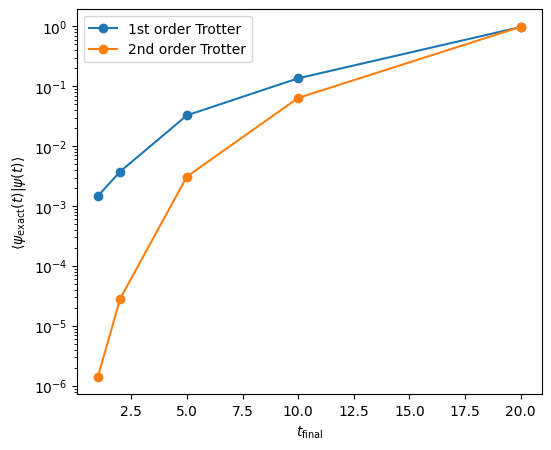

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
axs.plot(t_final_list, final_infid_tf_order1, marker='o', label="1st order Trotter")
axs.plot(t_final_list, final_infid_tf_order2, marker='o', label="2nd order Trotter")
# axs.plot(t_final_list, [0.01*(2 * x)**2/(x/dt) for x in t_final_list], marker='o', label="1st order error")
# axs.plot(t_final_list, [0.01*(2 * x)**3/(x/dt)**2 for x in t_final_list], marker='o', label="2nd order error")
axs.set_yscale("log")
axs.set_xlabel(rf"$t_{{\rm final}}$")
axs.set_ylabel(rf"$\langle \psi_{{\rm exact}}(t) | \psi(t) \rangle$")
axs.legend()